In [51]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

from statsforecast import StatsForecast
from statsforecast.models import CrostonOptimized, ADIDA, TSB, HoltWinters
from statsforecast.core import StatsForecast

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation


warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

In [3]:
url = "https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesForecastingInPython/refs/heads/master/data/intermittent_time_series.csv"
df = pd.read_csv(url, parse_dates=['ds'])
df.head()

,unique_id,ds,y
0,1,2023-01-01 00:00:00,43
1,1,2023-01-01 01:00:00,87
2,1,2023-01-01 02:00:00,89
3,1,2023-01-01 03:00:00,87
4,1,2023-01-01 04:00:00,73


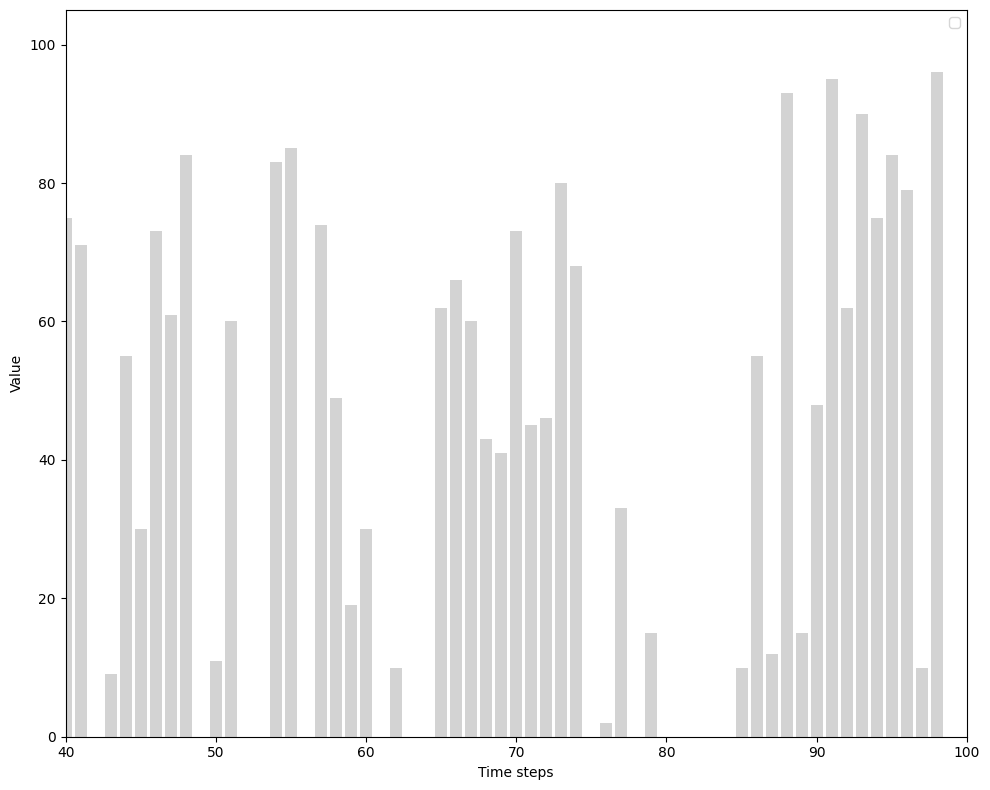

In [5]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(df.index, df['y'], color='lightgray')
ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()

## Croston

In [7]:
models = [CrostonOptimized()]

sf = StatsForecast(
    df=df,
    models=models,
    freq='H',
    n_jobs=-1
)

cv_df = sf.cross_validation(
    df=df,
    h=1,
    step_size=1,
    n_windows=50
)

cv_df.index = np.arange(50, 100, 1)

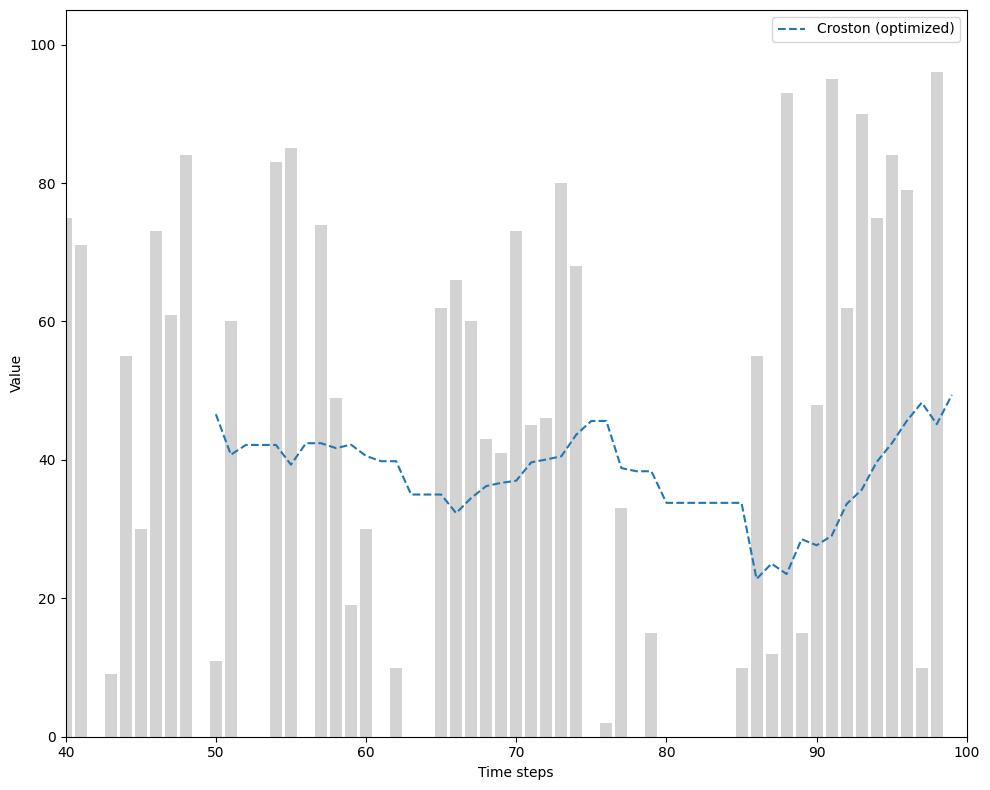

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(df.index, df['y'], color='lightgray')
ax.plot(cv_df.index, cv_df['CrostonOptimized'], ls='--', label='Croston (optimized)')
ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()

## ADIDA

In [10]:
models = [CrostonOptimized(), ADIDA()]

sf = StatsForecast(
    df=df,
    models=models,
    freq='H',
    n_jobs=-1
)

cv_df = sf.cross_validation(
    df=df,
    h=1,
    step_size=1,
    n_windows=50
)

cv_df.index = np.arange(50, 100, 1)

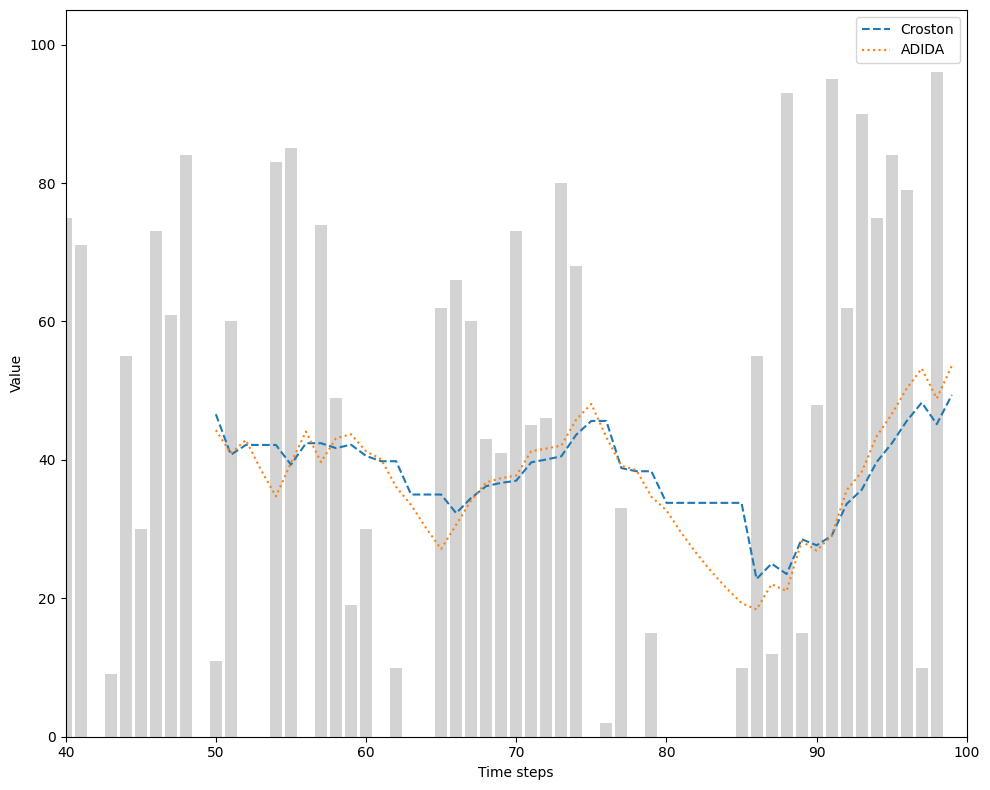

In [11]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(df.index, df['y'], color='lightgray')
ax.plot(cv_df.index, cv_df['CrostonOptimized'], ls='--', label='Croston')
ax.plot(cv_df.index, cv_df['ADIDA'], ls=':', label='ADIDA')
ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()


## TSB

In [13]:
models = [TSB(0.1, 0.1), ADIDA(), CrostonOptimized()]

sf = StatsForecast(
    df=df,
    models=models,
    freq='H',
    n_jobs=-1
)

cv_df = sf.cross_validation(
    df=df,
    h=1,
    step_size=1,
    n_windows=50
)

cv_df.index = np.arange(50, 100, 1)

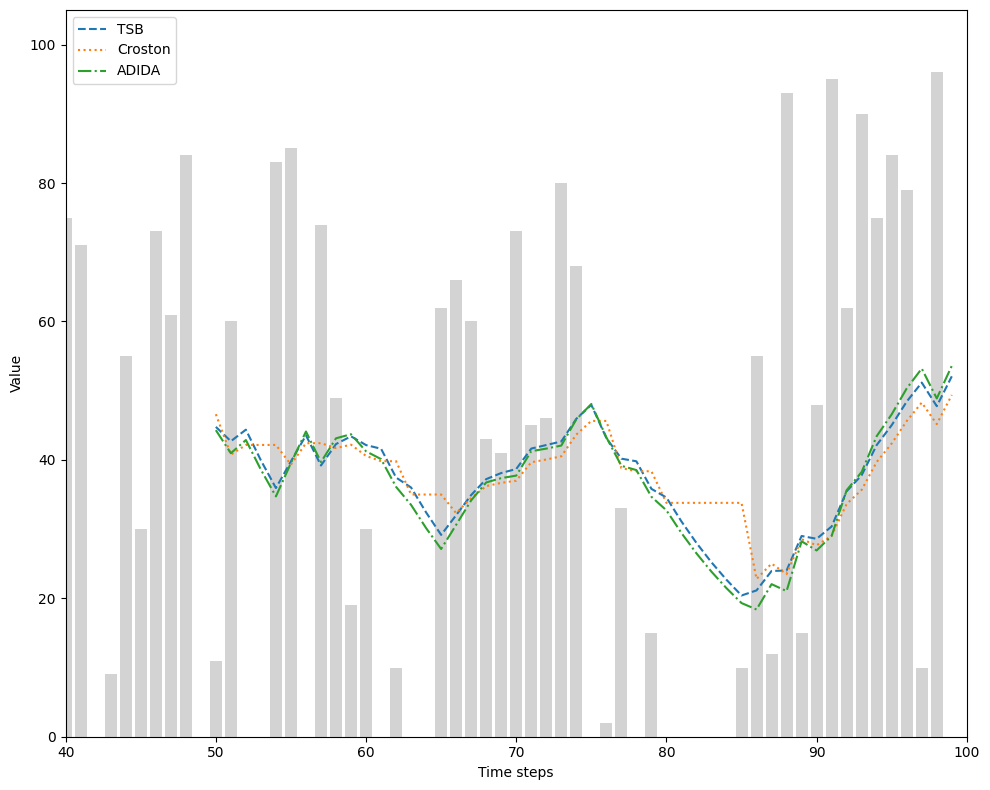

In [14]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(df.index, df['y'], color='lightgray')
ax.plot(cv_df.index, cv_df['TSB'], ls='--', label='TSB')
ax.plot(cv_df.index, cv_df['CrostonOptimized'], ls=':', label='Croston')
ax.plot(cv_df.index, cv_df['ADIDA'], ls='-.', label='ADIDA')

ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()

## Error metrics (CFE, CFE_min, CFE_max, PIS, NOS)

In [16]:
def errors(y_true, y_pred):
    
    # CFE
    cfe_all = np.cumsum(y_true - y_pred)
    cfe = cfe_all.iloc[-1]
    
    cfe_max = np.max(cfe_all)
    cfe_min = np.min(cfe_all)
    
    # PIS
    pis_all = -np.cumsum(cfe_all)
    pis = pis_all.iloc[-1]
    
    # NOS
    nos = len(cfe_all[cfe_all > 0])

    errors = {
        "CFE": cfe,
        "CFE_max": cfe_max,
        "CFE_min": cfe_min,
        "PIS": pis,
        "NOS": nos
    }
    
    return errors

In [17]:
croston_errors = errors(cv_df['y'], cv_df['CrostonOptimized'])
adida_errors = errors(cv_df['y'], cv_df['ADIDA'])
tsb_errors = errors(cv_df['y'], cv_df['TSB'])

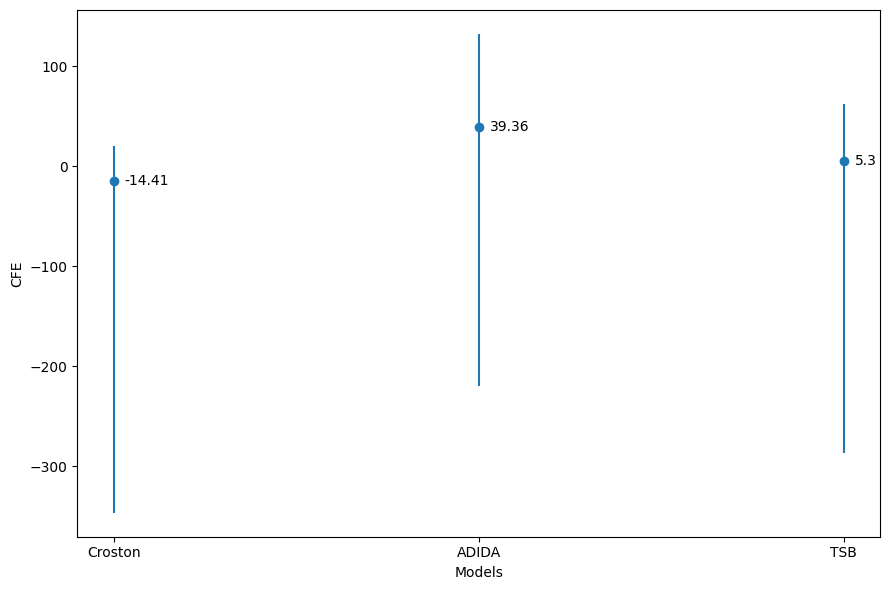

In [20]:
fig, ax = plt.subplots(figsize=(9,6))

x = ['Croston', 'ADIDA', 'TSB']
y = [croston_errors['CFE'], adida_errors['CFE'], tsb_errors['CFE']]

errors = [
    [abs(croston_errors['CFE_min']), abs(adida_errors['CFE_min']), abs(tsb_errors['CFE_min'])],
    [croston_errors['CFE_max'], adida_errors['CFE_max'], tsb_errors['CFE_max']]
]

ax.errorbar(x, y, yerr=errors, fmt='o')
ax.set_xlabel('Models')
ax.set_ylabel('CFE')

for i, v in enumerate(y):
    plt.text(x=i+0.03, y=v, s=str(round(v,2)), va='center')

plt.tight_layout()

## Hierarchical forecasting

In [19]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.head()

,Country,Region,State,Purpose,ds,y
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.078
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.035
3,Australia,Adelaide,South Australia,Business,1998-10-01,127.160
4,Australia,Adelaide,South Australia,Business,1999-01-01,137.449


In [20]:
spec = [
    ['Country'],
    ['Country', 'State'], 
    ['Country', 'Purpose'], 
    ['Country', 'State', 'Region'], 
    ['Country', 'State', 'Purpose'], 
    ['Country', 'State', 'Region', 'Purpose']
]

In [21]:
Y_df, S_df, tags = aggregate(Y_df, spec)
Y_df = Y_df.reset_index()

In [22]:
Y_df.head()

,unique_id,ds,y
0,Australia,1998-01-01,23182.197
1,Australia,1998-04-01,20323.380
2,Australia,1998-07-01,19826.641
3,Australia,1998-10-01,20830.130
4,Australia,1999-01-01,22087.353


In [23]:
S_df.iloc[:5, :5]

,Australia/ACT/Canberra/Business,Australia/ACT/Canberra/Holiday,Australia/ACT/Canberra/Other,Australia/ACT/Canberra/Visiting,Australia/New South Wales/Blue Mountains/Business
Australia,1.0,1.0,1.0,1.0,1.0
Australia/ACT,1.0,1.0,1.0,1.0,0.0
Australia/New South Wales,0.0,0.0,0.0,0.0,1.0
Australia/Northern Territory,0.0,0.0,0.0,0.0,0.0
Australia/Queensland,0.0,0.0,0.0,0.0,0.0


In [24]:
Y_df.head()

,unique_id,ds,y
0,Australia,1998-01-01,23182.197
1,Australia,1998-04-01,20323.380
2,Australia,1998-07-01,19826.641
3,Australia,1998-10-01,20830.130
4,Australia,1999-01-01,22087.353


In [26]:
tags['Country/State']

array(['Australia/ACT', 'Australia/New South Wales',
       'Australia/Northern Territory', 'Australia/Queensland',
       'Australia/South Australia', 'Australia/Tasmania',
       'Australia/Victoria', 'Australia/Western Australia'], dtype=object)

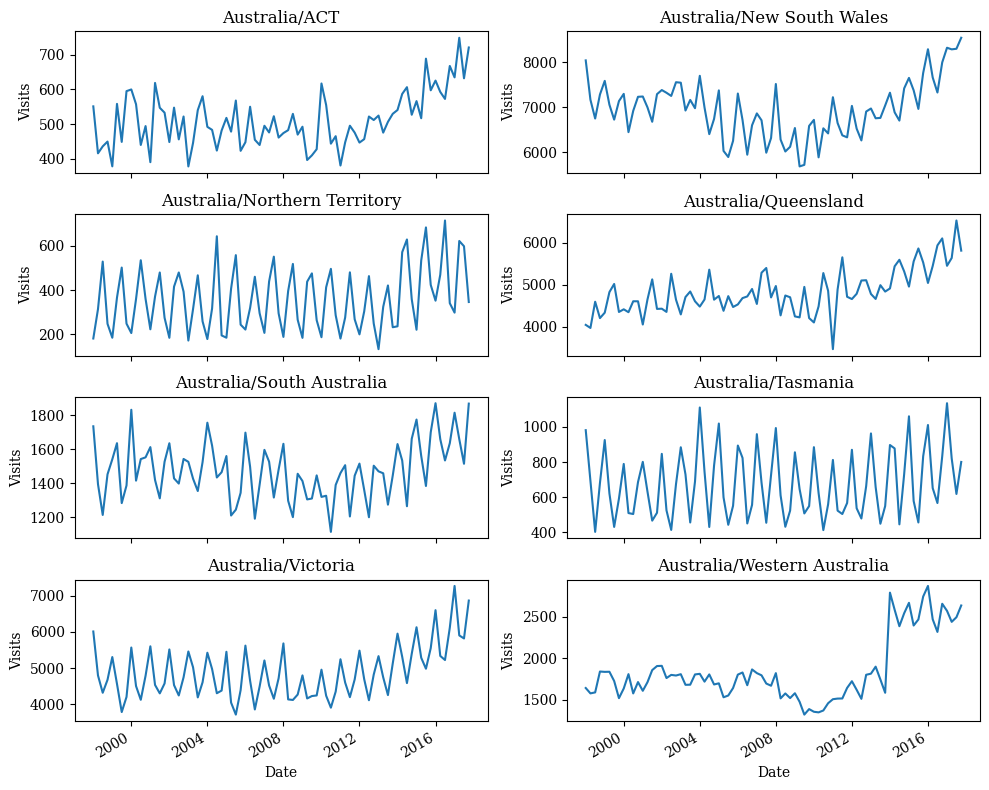

In [58]:
states = tags['Country/State']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8))
axes = axes.flatten()

for i, (ax, state) in enumerate(zip(axes, states)):
    plot_df = Y_df.query("unique_id == @state")

    ax.plot(plot_df['ds'], plot_df['y'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Visits')
    ax.set_title(state)

fig.autofmt_xdate()
plt.tight_layout()

In [27]:
Y_test_df = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

In [28]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [32]:
fcst = StatsForecast(
    df=Y_train_df, 
    models=[HoltWinters(season_length=4)], 
    freq='QS', 
    n_jobs=-1
)

Y_hat_df = fcst.forecast(h=8, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

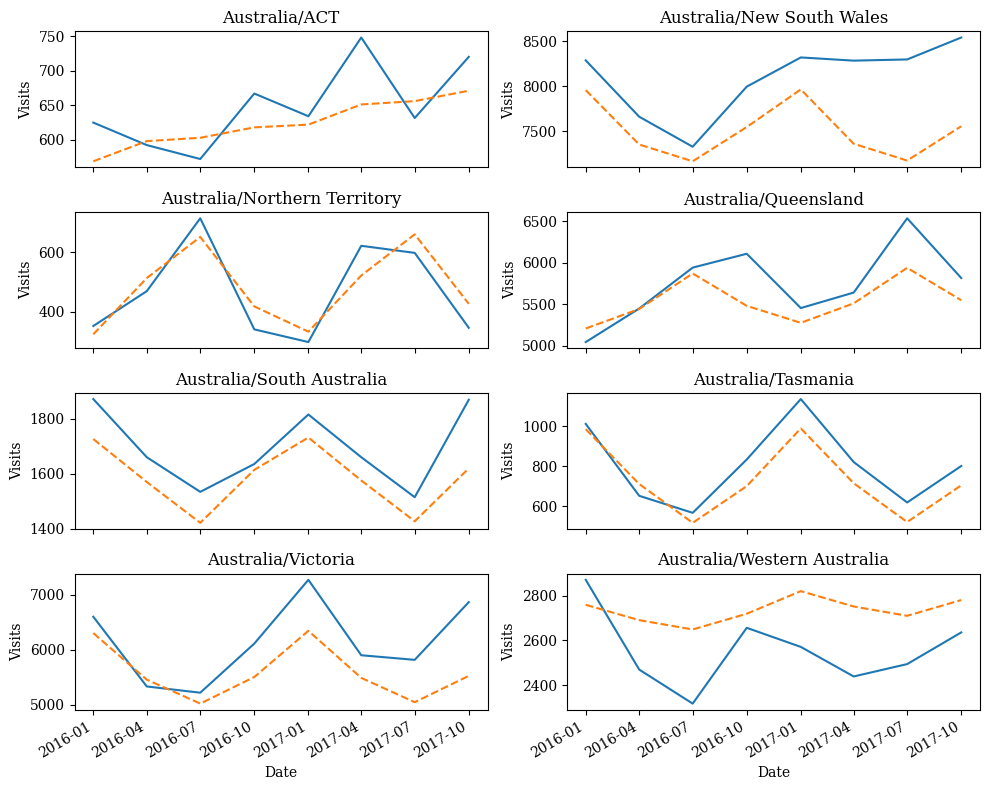

In [60]:
states = tags['Country/State']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8))
axes = axes.flatten()

for i, (ax, state) in enumerate(zip(axes, states)):
    pred_plot_df = Y_hat_df.query("unique_id == @state")
    actual_plot_df = Y_test_df.query("unique_id == @state")

    ax.plot(actual_plot_df['ds'], actual_plot_df['y'])
    ax.plot(pred_plot_df['ds'], pred_plot_df['HoltWinters'], ls='--', label='Holt-Winters')

    ax.set_xlabel('Date')
    ax.set_ylabel('Visits')
    ax.set_title(state)

fig.autofmt_xdate()
plt.tight_layout()

In [46]:
reconcilers = [
    BottomUp(),
    MinTrace(method='ols')
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(
    Y_hat_df=Y_hat_df, 
    Y_df=Y_fitted_df, 
    S=S_df, 
    tags=tags
)

In [47]:
Y_rec_df = Y_rec_df.drop(['index', 'index/BottomUp', 'index/MinTrace_method-ols'], axis=1)
Y_rec_df.head()

,ds,HoltWinters,HoltWinters/BottomUp,HoltWinters/MinTrace_method-ols
unique_id,,,,
Australia,2016-01-01,26082.627,24541.799,26047.634
Australia,2016-04-01,24561.693,23047.967,24553.940
Australia,2016-07-01,24121.705,22698.645,24139.874
Australia,2016-10-01,24799.992,23449.035,24845.524
Australia,2017-01-01,26281.235,24994.600,26353.334


In [61]:
def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

eval_tags = {}
eval_tags['Country'] = tags['Country']
eval_tags['Purpose'] = tags['Country/Purpose']
eval_tags['State'] = tags['Country/State']
eval_tags['Regions'] = tags['Country/State/Region']
eval_tags['Bottom'] = tags['Country/State/Region/Purpose']
eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, 
        Y_test_df=Y_test_df,
        tags=eval_tags, 
        Y_df=Y_train_df
)

evaluation = evaluation.drop('Overall')
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(ols)']
evaluation = evaluation.applymap('{:.2f}'.format)

In [62]:
evaluation.query('metric == "rmse"')

,,Base,BottomUp,MinTrace(ols)
level,metric,,,
Country,rmse,1484.55,2620.52,1406.15
Purpose,rmse,341.67,695.46,425.46
State,rmse,284.23,399.99,268.80
Regions,rmse,46.19,53.96,43.47
Bottom,rmse,19.53,19.53,18.17
All,rmse,41.17,52.51,39.82
